# Pretty images of already reduced data for visualisation. 

Both IRDIS and ZIMPOL data are used here.
 
First part of the code is for individual stars and then for set of stars for publication reasons

## Functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
import functions as f
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties


def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    return dirname

In [6]:


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
  

    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm



def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp
    

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr
    

    
    
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim,aolp_plot=False):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas',fontsize=14)
    plt.ylabel("mas",fontsize=14)
     
    ax.tick_params(axis='both',labelsize=14)
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    #psi=ndimage.gaussian_filter(psi, sigma=(1, 1), order=0) #smooting by gaussian filter   
            
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    #mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2#*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    if aolp_plot:
        pixX = frac*np.cos(psi+np.pi/2) # X-vector 
        pixY = frac*np.sin(psi+np.pi/2) # Y-vector

        # keyword arguments for quiverplots
        quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
        ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title,fontsize=16)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
    
    
def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    print(dirdat)
    qfile = '*_'+band+'_I_meancombined.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n




def LoadImage(dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            # ps =3.6
            ps=12.27
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2


      
def maskcrit(aolp,R):
    phi = (aolp) #ndimage.gaussian_filter(aolp, sigma=(2, 2), order=1)#
    
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>np.pi/2:
                #print(phi[ix,iy])
                phi[ix,iy]=phi[ix,iy]-np.pi/2
            
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]<-np.pi/2:
                
                phi[ix,iy]=phi[ix,iy]+np.pi/2      
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmean(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask



## Set up

In [14]:

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
stars=['HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','01.SCI_UMon','01.SCI_AR_Pup']

star = stars[-2]

#star='IRAS08544-4431_dc_notnorm'

starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':'AR Pup'}
stars_type={'01.SCI_UMon':'sci','UMon':'sci','HD71253':'ref','REF_HD71253':'ref','01.SCI_AR_Pup':'sci','REF_HD75885':'ref'}
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','UMon':'HD71253','01.SCI_UMon':'01.SCI_UMon','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
# REF_HD71253
fittypes=['1', '2']
# fittypes=['1']

band=['V','I']
# band=['H']
ps=3.6
# ps=12.27



## Code

In [15]:
camera = 'ZIMPOL'
dirdat0 ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel+unres/'+camera+'/'
dirdat ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unresolved_images/'+camera+'/'
create_dir(figfolder)

#limit for normalisation
normlim=125/ps
correction_radius=3

for fittype in fittypes:
    print(band[int(fittype)-1])
    
    q, n=Loadimages(star,'Q',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    q_phi, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    u, n=Loadimages(star,'U',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    pi, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    
    i,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band[int(fittype)-1])
    fwhm=find_FWHM (i,n)*ps
    
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)

   
    q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
    u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
    pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear 
  
    I_decon, _, _, _, _,_,_=  LoadImage(dirdat0 +'deconvolved_'+'I'+'/',band[int(fittype)-1])
    q_phi_decon, _, _, _, _,_,_=  LoadImage(dirdat0 +'deconvolved_'+'Q_phi'+'/',band[int(fittype)-1])
    pi_decon, _, _, _, _,_,_=  LoadImage(dirdat0 +'deconvolved_'+'PI'+'/',band[int(fittype)-1])
    fwhm_deconv=find_FWHM (I_decon,n)*ps
        
    if band[int(fittype)-1]=='V':
        q_phi_V_with_unres=q_phi
        q_phi_V=q_phi_corr
        pi_V_with_unres=pi
        pi_V=pi_corr
        fwhm_V=fwhm

        q_phi_deconv_V=q_phi_decon
        pi_deconv_V=pi_decon
        fwhm_deconv_V=fwhm_deconv
        
    if band[int(fittype)-1]=='I':
        q_phi_I_with_unres=q_phi
        q_phi_I=q_phi_corr
        pi_I_with_unres=pi
        pi_I=pi_corr
        fwhm_I=fwhm
        
        q_phi_deconv_I=q_phi_decon
        pi_deconv_I=pi_decon
        fwhm_deconv_I=fwhm_deconv

    if band[int(fittype)-1]=='H':
        q_phi_H_with_unres=q_phi
        q_phi_H=q_phi_corr
        pi_H_with_unres=pi
        pi_H=pi_corr
        fwhm_H=fwhm

        q_phi_deconv_H=q_phi_decon
        pi_deconv_H=pi_decon
        fwhm_deconv_H=fwhm_deconv



    #plt.xlabel('mas')
    #plt.ylabel("mas")
    #plt.colorbar()
    #plt.tight_layout        

        
        
    

V
0.0
1.0000000000000003e-16
0.0
0.0
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unres+PSFcorr/ZIMPOL/
*_V_I_meancombined.fits
1024
0.0020265706656047745
-0.0033337099177753768
0.0038811832
I
0.0
1.0000000000000003e-16
0.0
0.0
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unres+PSFcorr/ZIMPOL/
*_I_I_meancombined.fits
1024
0.017662204361924953
-0.0633224407257182
0.06554342


In [16]:
fwhm

np.float64(27.855325290814605)

In [27]:
fwhm_deconv

np.float64(30.936215528936128)

### before and after correction of unresolved polarisation with I, V and H bands

In [28]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unresolved_images/ZIMPOL/'

<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\m'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_12659/2566450592.py:44: SyntaxWarning: invalid escape sequence '\p'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_12659/2566450592.py:44: SyntaxWarning: invalid escape sequence '\m'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_12659/2566450592.py:44: SyntaxWarning: invalid escape sequence '\p'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{po

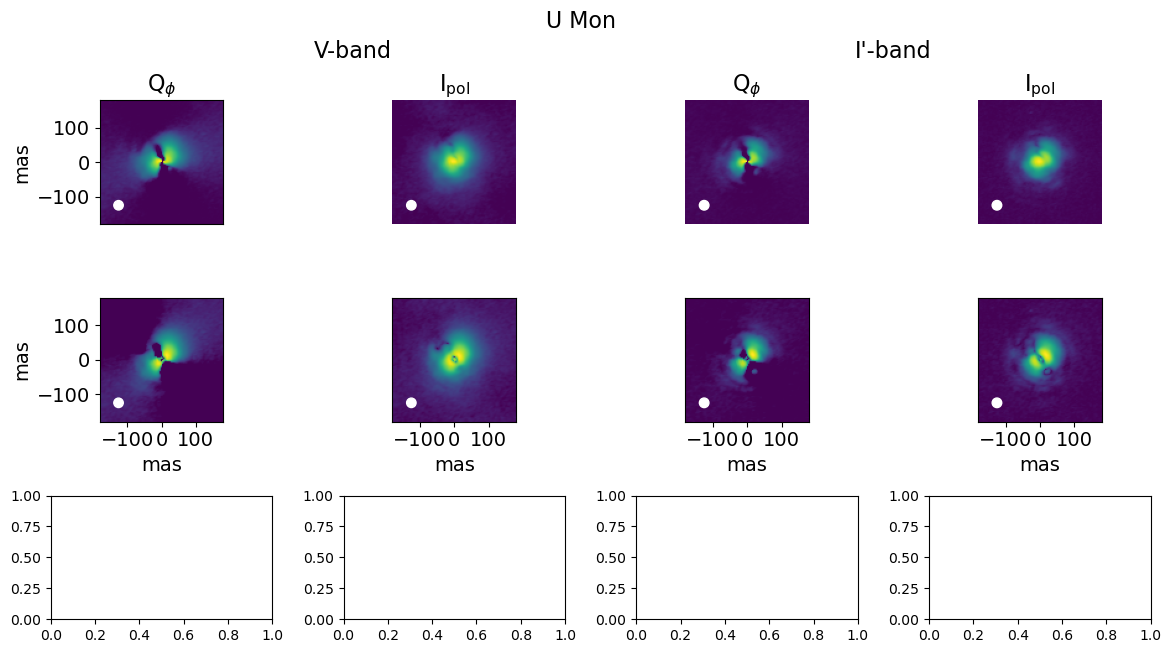

In [17]:


d = (n-1) * ps / 2
lim=50
if star==stars[0]: lim=130

fig, axs = plt.subplots(3, 4, figsize=(12, 6))

# Only ZIMPOL
images_list=[q_phi_V_with_unres,pi_V_with_unres,q_phi_I_with_unres,pi_I_with_unres, q_phi_V,pi_V,q_phi_I,pi_I]
bandlist=['V','V','I','I','V','V','I','I']

#IRDIS
# images_list=[q_phi_H_with_unres, pi_H_with_unres, q_phi_H, pi_H]
# bandlist=['H','H','H','H']

i_im=0
for ax, image,band in zip(axs.flat,images_list,bandlist):
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


    ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    ax.set_xlim(-lim * ps, lim * ps)
    ax.set_ylim(-lim * ps, lim * ps)
    ax.set_xlabel('mas',fontsize=14)
    ax.set_ylabel('mas',fontsize=14)
    #ax.set_yticks([-130,-100,-50,0,50,100])
    #ax.set_yticks(fontsize=14)
    ax.tick_params(axis='both',labelsize=14)
    ax.grid(False)
    if star==stars[0]:
        circleloc=(-300,-300)
    else:
        circleloc=(-125,-125)
    if band=='V':
        circle1 =plt.Circle(circleloc, (fwhm_V/2), color='w')
        ax.add_patch(circle1)
    else:
        circle1 =plt.Circle(circleloc, (fwhm_I/2), color='w')
        ax.add_patch(circle1)

    i_im+=1
col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']


for ax, col_title in zip(axs[0], col_titles):
    ax.set_title(col_title, fontsize=16)


for i in range(3):
    axs[0,i+1].axis('off')
    axs[1,i+1].get_yaxis().set_visible(False)
axs[0,0].get_xaxis().set_visible(False)

plt.tight_layout()
fig.text(0.5, 1.05, starnames[star], fontsize=16, ha='center')

fig.text(0.31, 1, 'V-band', fontsize=16, ha='center')
fig.text(0.76, 1, "I'-band", fontsize=16, ha='center')
# fig.text(0.76, 1, "H'-band", fontsize=16, ha='center')


plt.savefig(figfolder+star+'_VIunresolved.png',bbox_inches='tight')
plt.show()
plt.close()

In [13]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unresolved_images/IRDIS/'

### before and after deconvolution with I and V bands

In [30]:
print(starnames[star])

AR Pup


<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_24528/2225372946.py:45: SyntaxWarning: invalid escape sequence '\p'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_24528/2225372946.py:45: SyntaxWarning: invalid escape sequence '\m'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_24528/2225372946.py:45: SyntaxWarning: invalid escape sequence '\p'
  col_titles = ['Q$_\phi$', 'I$_{\mathrm{po

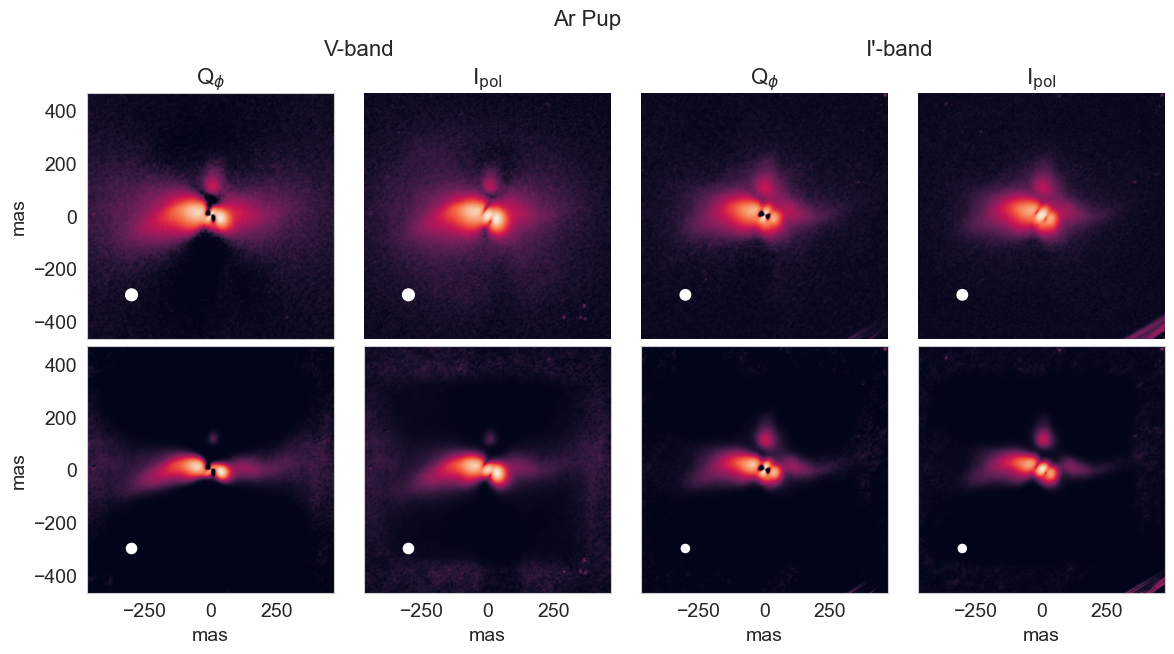

In [54]:

d = n * ps / 2
lim=50
if star==stars[0]: lim=130

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
images_list=[q_phi_V,pi_V,q_phi_I,pi_I,q_phi_deconv_V,pi_deconv_V,q_phi_deconv_I,pi_deconv_I]
bandlist=['V','V','I','I','V','V','I','I']
i_im=0
for ax, image,band in zip(axs.flat,images_list,bandlist):
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


    ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    ax.set_xlim(-lim * ps, lim * ps)
    ax.set_ylim(-lim * ps, lim * ps)
    ax.set_xlabel('mas',fontsize=14)
    ax.set_ylabel('mas',fontsize=14)
    #ax.set_yticks([-130,-100,-50,0,50,100])
    #ax.set_yticks(fontsize=14)
    ax.tick_params(axis='both',labelsize=14)
    ax.grid(False)

    if star==stars[0]:
        circleloc=(-300,-300)
    else:
        circleloc=(-125,-125)
    if band=='V':
        if i_im<4:
            circle1 =plt.Circle(circleloc, (fwhm_V/2), color='w')
        else:
            circle1 =plt.Circle(circleloc, (fwhm_deconv_V/2), color='w')

        ax.add_patch(circle1)
    else:
        if i_im<4:
            circle1 =plt.Circle(circleloc, (fwhm_I/2), color='w')
        else:
            circle1 =plt.Circle(circleloc, (fwhm_deconv_I/2), color='w')
        ax.add_patch(circle1)

    i_im+=1
col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']


for ax, col_title in zip(axs[0], col_titles):
    ax.set_title(col_title, fontsize=16)


for i in range(3):
    axs[0,i+1].axis('off')
    axs[1,i+1].get_yaxis().set_visible(False)
axs[0,0].get_xaxis().set_visible(False)

plt.tight_layout()
fig.text(0.5, 1.05, starnames[star], fontsize=16, ha='center')
fig.text(0.31, 1, 'V-band', fontsize=16, ha='center')
fig.text(0.76, 1, "I'-band", fontsize=16, ha='center')


plt.savefig(figfolder+star+'_deconvolved.png',bbox_inches='tight')
plt.show()
plt.close()

In [32]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unresolved_images/ZIMPOL/'

### PI with statistically significant region


0.0003385593581415474
-0.0036766829885752327
0.0036885215
0.010740904


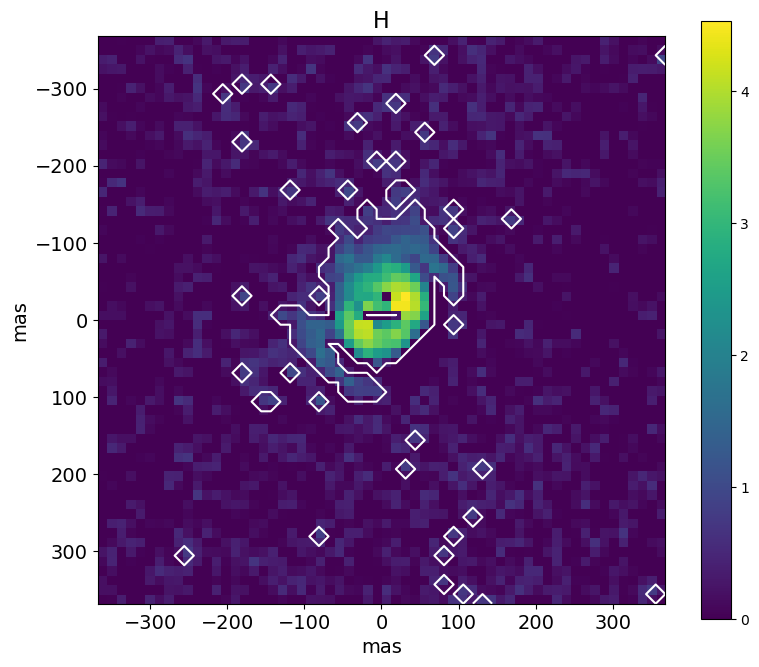

In [33]:
camera = 'IRDIS'

dirdat ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unresolved_images/'+'Extra_images/'
createfolder(figfolder)
band='H'

# datafr=pd.read_csv(dirdat+star+'_'+band+'_df_out.csv')
# datafr.xs('noise_q_phi_median',axis=1)
# print(datafr.xs('noise_q_phi_median',axis=1).median())
#
# print(datafr.xs('noise_pi_median',axis=1).median())

q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band,'_corr_tel+unres') #+PSF_smear
u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band,'_corr_tel+unres') #+PSF_smear
pi_corr, n=Loadimages(star,'PI',dirdat,band,'_corr_tel+unres') #+PSF_smear
i, n=Loadimages(star,'PI',dirdat,band,'_meancombined') #+PSF_smear

# ps=3.6
ps=12.27
 #Creating grid         
xr = np.linspace(-n/2, n/2, num=n)
yr = np.linspace(-n/2, n/2, num=n)
x0 = 0.5
y0 = 0.5
xr = xr-x0
yr = yr-y0
Xr, Yr = np.meshgrid(xr, yr)
R = np.sqrt(Xr**2 + Yr**2)
phi = np.arctan(Yr/Xr)

plot_AoLP(ps,q,u,R,i,q_phi_corr,band,figfolder+star+'_'+band+'_snr_qphi_not_smear.png',True, 0.15,30)
# plot_AoLP(ps,q,u,R,i,pi,band,figfolder+star+'_'+band+'_snr_qphi_not_smear.png',True, datafr.xs('noise_pi_median',axis=1).median(),70)
#plot_AoLP(ps,q_corr,u_corr,R,i,pi_corr,band[int(fittype)-1],figfolder_snr+star+'_'+band[int(fittype)-1]+'_snr_pi_not_smear.png',True, df.xs('noise_pi_median',axis=1).median(),50)
        

### Set of stars 

01.SCI_AR_Pup
V
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_V_I_meancombined.fits
1024
1.0000000000000003e-16
0.0
0.0
fwhm 44.607111536785105 38.656562349314385
I
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_I_I_meancombined.fits
1024
1.0000000000000003e-16
0.0
0.0
fwhm 39.764951577697815 30.936215528936128


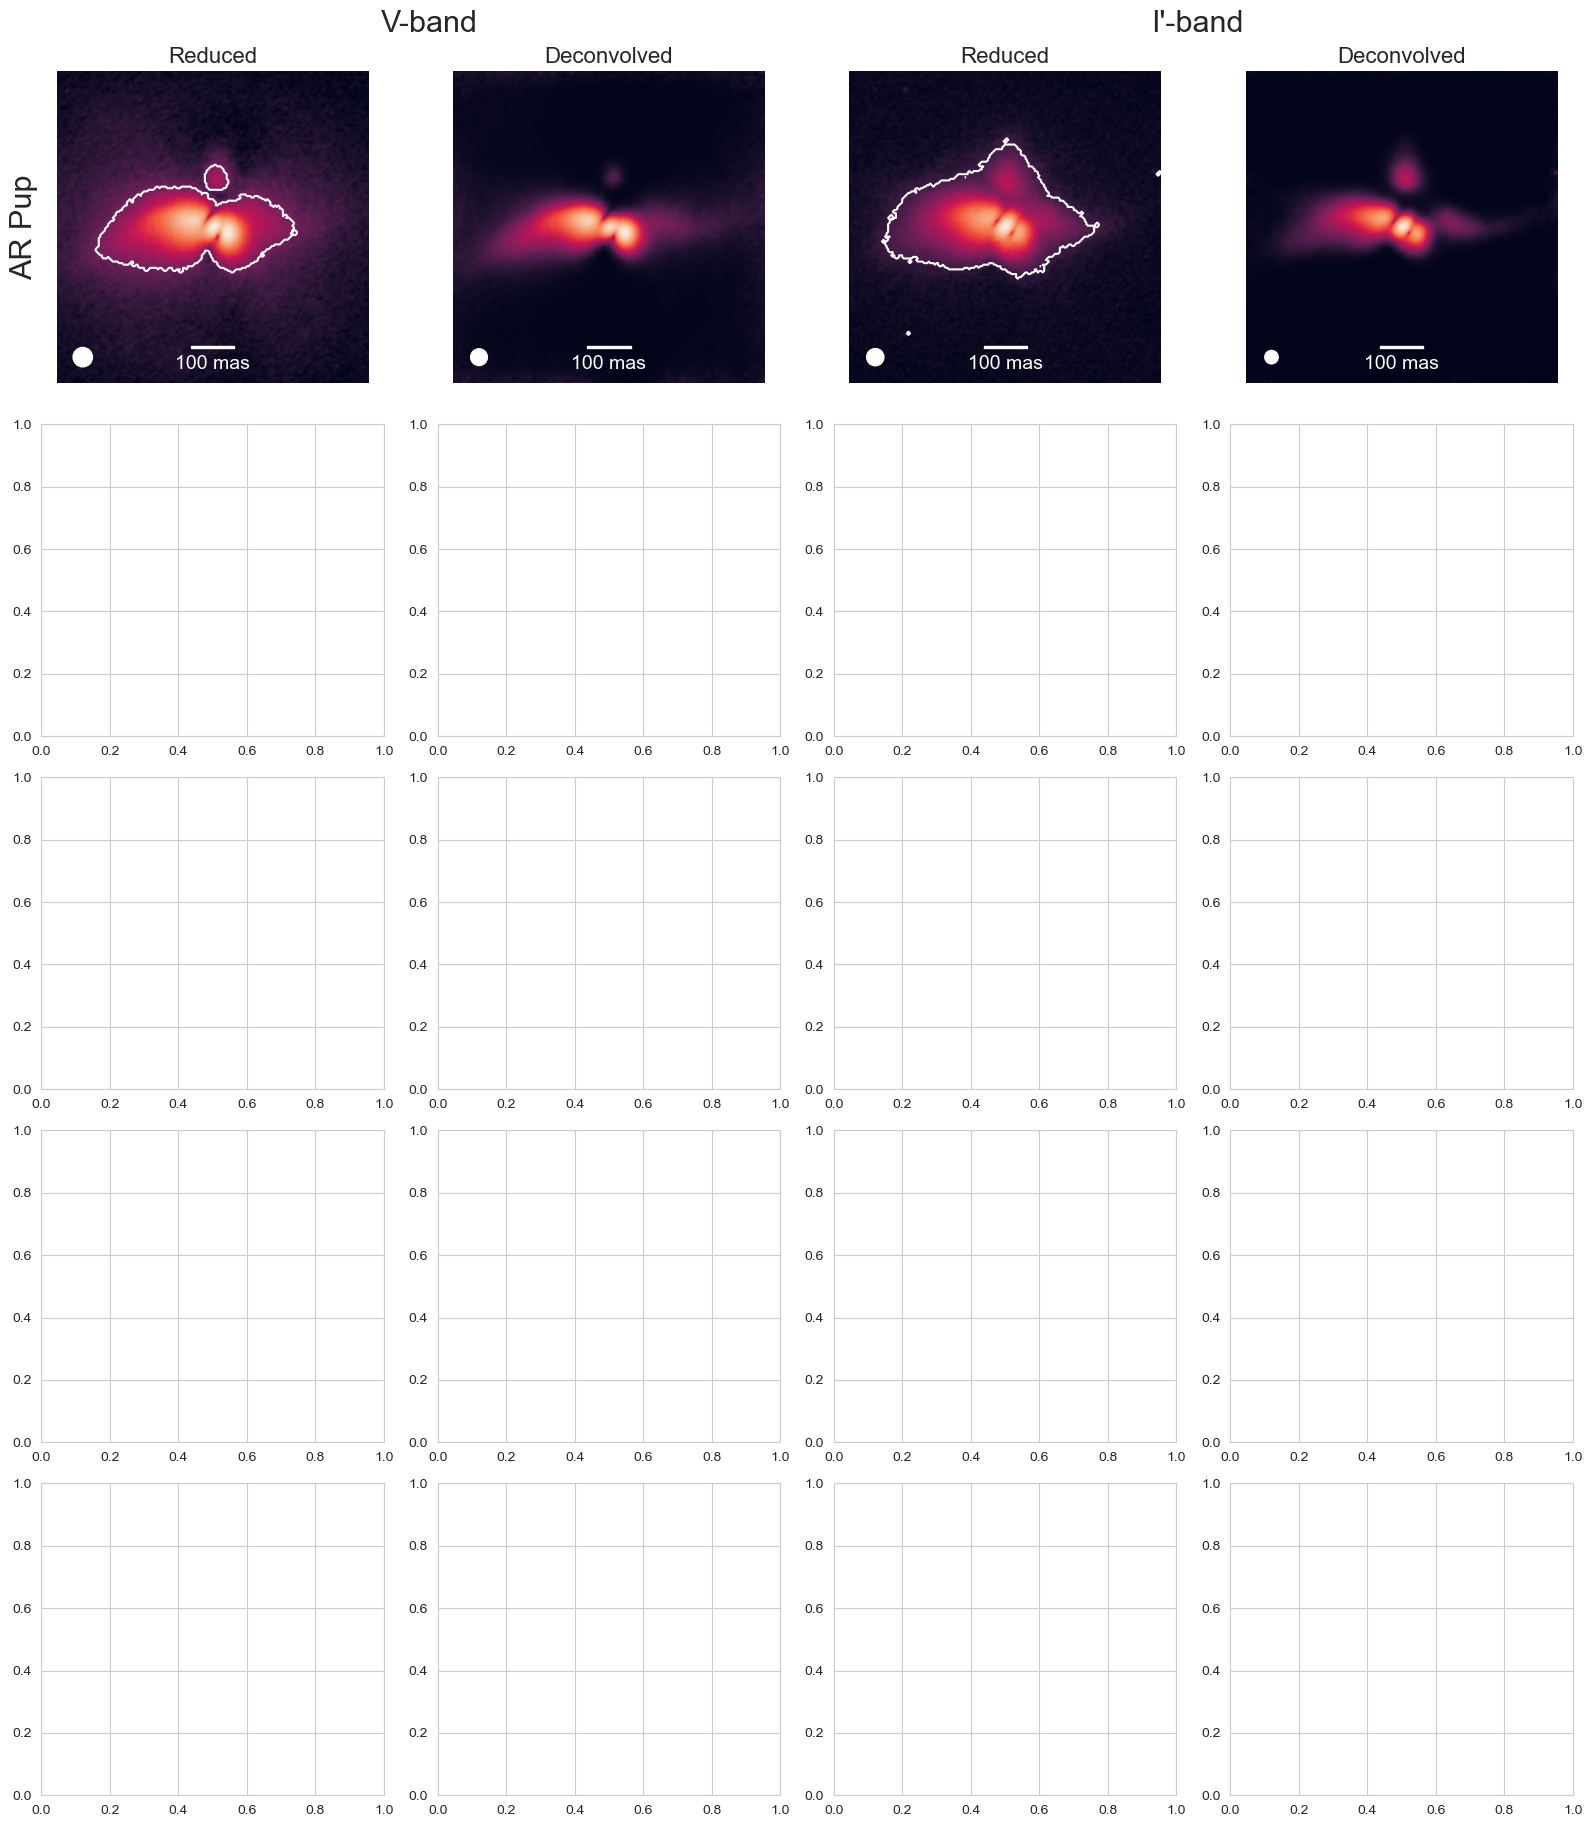

In [44]:


stars=['01.SCI_AR_Pup']

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unresolved_images/'+'Extra_images/'
ps=3.6
band=['V','I']


fig, ax = plt.subplots(5, 4, figsize=(16, 18))

for i_st,star in enumerate(stars):
    print(star)
    dirdat ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

    if star=='AR_Pup_dc_notnorm':
        dirdatd ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Deconvolution_corr_tel/'+star+'/'
    else:
        dirdatd ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera+'/'
    
    fittypes=['1', '2']

    df_V=pd.read_csv(dirdat+star+'_'+'V'+'_df_out.csv')
    df_I=pd.read_csv(dirdat+star+'_'+'I'+'_df_out.csv')

    for fittype in fittypes:
        print(band[int(fittype)-1])
        
        psf,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr_Ref/'+camera+'/',band[int(fittype)-1])
        fwhm=find_FWHM (psf,n)*ps

         #Creating grid         
        xr = np.linspace(-n/2, n/2, num=n)
        yr = np.linspace(-n/2, n/2, num=n)
        x0 = 0.5
        y0 = 0.5
        xr = xr-x0
        yr = yr-y0
        X, Y = np.meshgrid(xr, yr)
        R = np.sqrt(X**2 + Y**2)
        phi = np.arctan(Y/X)

        if star=='01.SCI_AR_Pup':
            q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
            u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
            pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear 
        else:
            q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
            u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
            pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear 

        I_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'I'+'/',band[int(fittype)-1])
        q_phi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'Q_phi'+'/',band[int(fittype)-1])
        pi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'PI'+'/',band[int(fittype)-1])
        
        fwhm_deconv=find_FWHM (I_decon,n)*ps
        print('fwhm',fwhm, fwhm_deconv)


        if band[int(fittype)-1]=='V':
            q_phi_V=q_phi_corr
            pi_V=pi_corr
            fwhm_V=fwhm
            q_phi_deconv_V=q_phi_decon
            pi_deconv_V=pi_decon
            fwhm_deconv_V=fwhm_deconv

        if band[int(fittype)-1]=='I':
            q_phi_I=q_phi_corr
            pi_I=pi_corr
            fwhm_I=fwhm
            q_phi_deconv_I=q_phi_decon
            pi_deconv_I=pi_decon
            fwhm_deconv_I=fwhm_deconv

    images_list=[pi_V,pi_deconv_V,pi_I,pi_deconv_I]
    bandlist=['V','V','I','I']
    d=(n-1)/2*ps
    if i_st==0:
        lim=100
    else:
        lim=50
    for i_im, image1 in enumerate(images_list):

        image = np.arcsinh(image1)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


        ax[i_st,i_im].imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        ax[i_st,i_im].set_xlim(-lim * ps, lim * ps)
        ax[i_st,i_im].set_ylim(-lim * ps, lim * ps)
        ax[i_st,i_im].tick_params(axis='both',labelsize=14)

        lenghtmas=100
        fp = FontProperties()
        fp.set_size(14)
        if i_st==0:
            asb = AnchoredSizeBar(ax[i_st,i_im].transData,
                              lenghtmas,
                              str(lenghtmas)+" mas",fontproperties=fp,
                              loc='lower center',
                              pad=0.1, borderpad=0.4, sep=5, size_vertical=5,
                              frameon=False, color='white')
        else:
            asb = AnchoredSizeBar(ax[i_st,i_im].transData,
                              lenghtmas,
                              str(lenghtmas)+" mas",fontproperties=fp,
                              loc='lower center',
                              pad=0.1, borderpad=0.4, sep=5, size_vertical=2,
                              frameon=False, color='white')
        ax[i_st,i_im].add_artist(asb)
        
        if star==stars[0]: 
            circleloc=(-300,-300)
        else:
            circleloc=(-125,-125)
            
        if bandlist[i_im]=='V':
            if i_im==0:
                circle1 =plt.Circle(circleloc, (fwhm_V/2), color='w') 
                mask= image1>=df_V.xs('noise_pi_median',axis=1).median()*3
   
                mask=mask.astype(int)
                levels = [0,1]  # Adjust this as needed
                CS = ax[i_st,i_im].contour(X*ps, Y*ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

            else:
                circle1 =plt.Circle(circleloc, (fwhm_deconv_V/2), color='w') 
                
            ax[i_st,i_im].add_patch(circle1)
        else:
            if i_im==2:
                circle1 =plt.Circle(circleloc, (fwhm_I/2), color='w')  
                mask= image1>=df_I.xs('noise_pi_median',axis=1).median()*3
   
                mask=mask.astype(int)
                levels = [0,1]  # Adjust this as needed
                CS = ax[i_st,i_im].contour(X*ps, Y*ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

            else:
                circle1 =plt.Circle(circleloc, (fwhm_deconv_I/2), color='w') 
                
            ax[i_st,i_im].add_patch(circle1)
        ax[i_st,i_im].axis('off')

    col_titles = ['Reduced', 'Deconvolved','Reduced', 'Deconvolved']


    for axi, col_title in zip(ax[0], col_titles):
        axi.set_title(col_title, fontsize=16)

    ax[i_st, 0].text(-0.15, 0.5, starnames[star], transform=ax[i_st, 0].transAxes, fontsize=22, va='center', rotation=90)


    
    plt.tight_layout()
    fig.text(0.27, 1, 'V-band', fontsize=22, ha='center')
    fig.text(0.75, 1, "I'-band", fontsize=22, ha='center')
    
plt.savefig(figfolder+'PI_reduced+deconv.png',bbox_inches='tight')
plt.show()
plt.close()


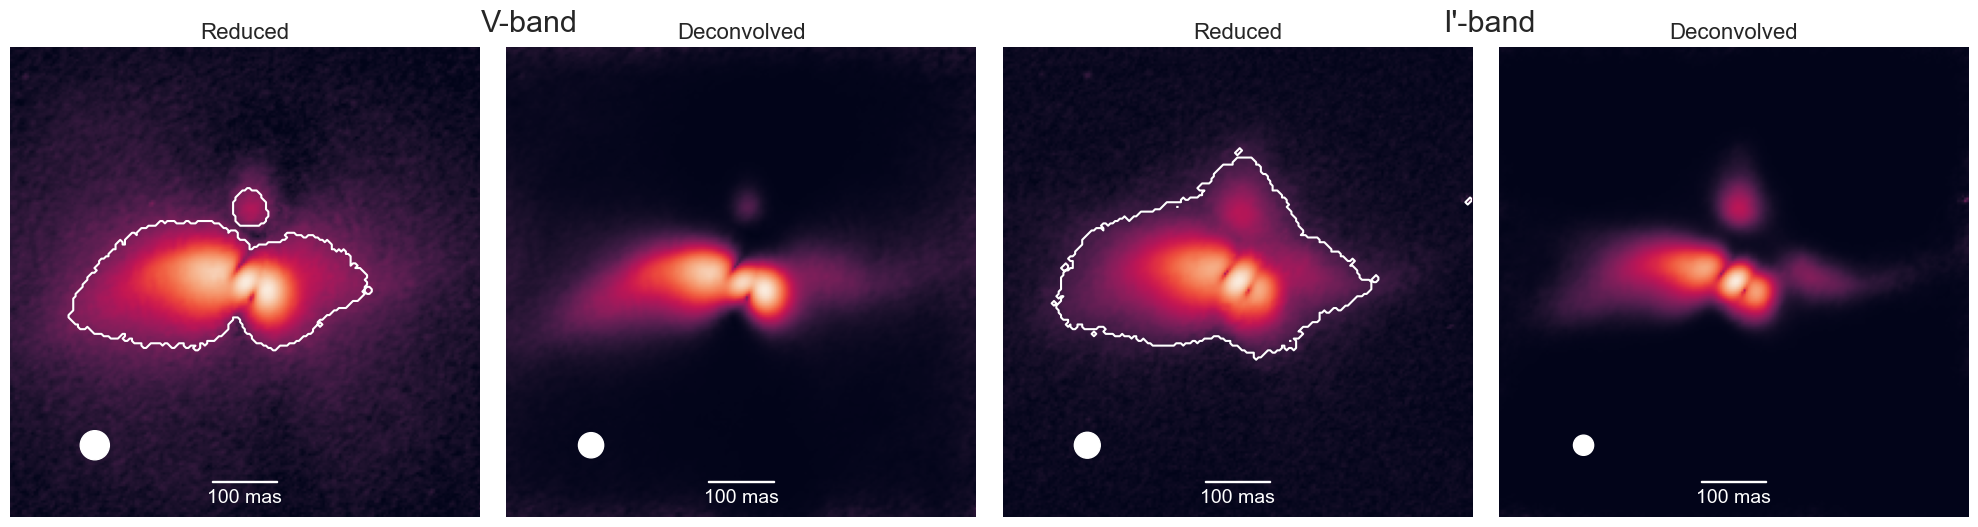

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5)) # Create a 1x4 subplot grid

lim = 100

for i_im, image1 in enumerate(images_list):
    image = np.arcsinh(image1)
    max_val = np.max(image[int(n/2-lim/2):int(n/2+lim/2), int(n/2-lim/2):int(n/2+lim/2)])
    min_val = np.min(image[int(n/2-lim/2):int(n/2+lim/2), int(n/2-lim/2):int(n/2+lim/2)])

    ax[i_im].imshow(image, vmin=min_val, vmax=max_val, extent=(-d, d, d, -d))
    ax[i_im].set_xlim(-lim * ps, lim * ps)
    ax[i_im].set_ylim(-lim * ps, lim * ps)
    ax[i_im].tick_params(axis='both', labelsize=14)

    lenghtmas = 100
    fp = FontProperties()
    fp.set_size(14)
    asb = AnchoredSizeBar(ax[i_im].transData,
                          lenghtmas,
                          str(lenghtmas) + " mas",
                          fontproperties=fp,
                          loc='lower center',
                          pad=0.1, borderpad=0.4, sep=5, size_vertical=2, #adjust size_vertical as needed
                          frameon=False, color='white')
    ax[i_im].add_artist(asb)

    circleloc = (-230, -250)

    if bandlist[i_im] == 'V':
        if i_im == 0:
            circle1 = plt.Circle(circleloc, (fwhm_V / 2), color='w')
            mask = image1 >= df_V.xs('noise_pi_median', axis=1).median() * 3
            mask = mask.astype(int)
            levels = [0, 1]
            CS = ax[i_im].contour(X * ps, Y * ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
        else:
            circle1 = plt.Circle(circleloc, (fwhm_deconv_V / 2), color='w')
        ax[i_im].add_patch(circle1)
    else:
        if i_im == 2:
            circle1 = plt.Circle(circleloc, (fwhm_I / 2), color='w')
            mask = image1 >= df_I.xs('noise_pi_median', axis=1).median() * 3
            mask = mask.astype(int)
            levels = [0, 1]
            CS = ax[i_im].contour(X * ps, Y * ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
        else:
            circle1 = plt.Circle(circleloc, (fwhm_deconv_I / 2), color='w')
        ax[i_im].add_patch(circle1)
    ax[i_im].axis('off')

col_titles = ['Reduced', 'Deconvolved', 'Reduced', 'Deconvolved']

for axi, col_title in zip(ax, col_titles):
    axi.set_title(col_title, fontsize=16)

fig.text(0.27, 1, 'V-band', fontsize=22, ha='center')
fig.text(0.75, 1, "I'-band", fontsize=22, ha='center')

plt.tight_layout()
plt.savefig(figfolder + 'PI_reduced+deconv.png', bbox_inches='tight')
plt.show()
plt.close()

01.SCI_AR_Pup
V
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_V_I_meancombined.fits
1024
1e-16
0.02913541879525069
0.07008718
I
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_I_I_meancombined.fits
1024
1e-16
0.04209847212355816
0.0564287


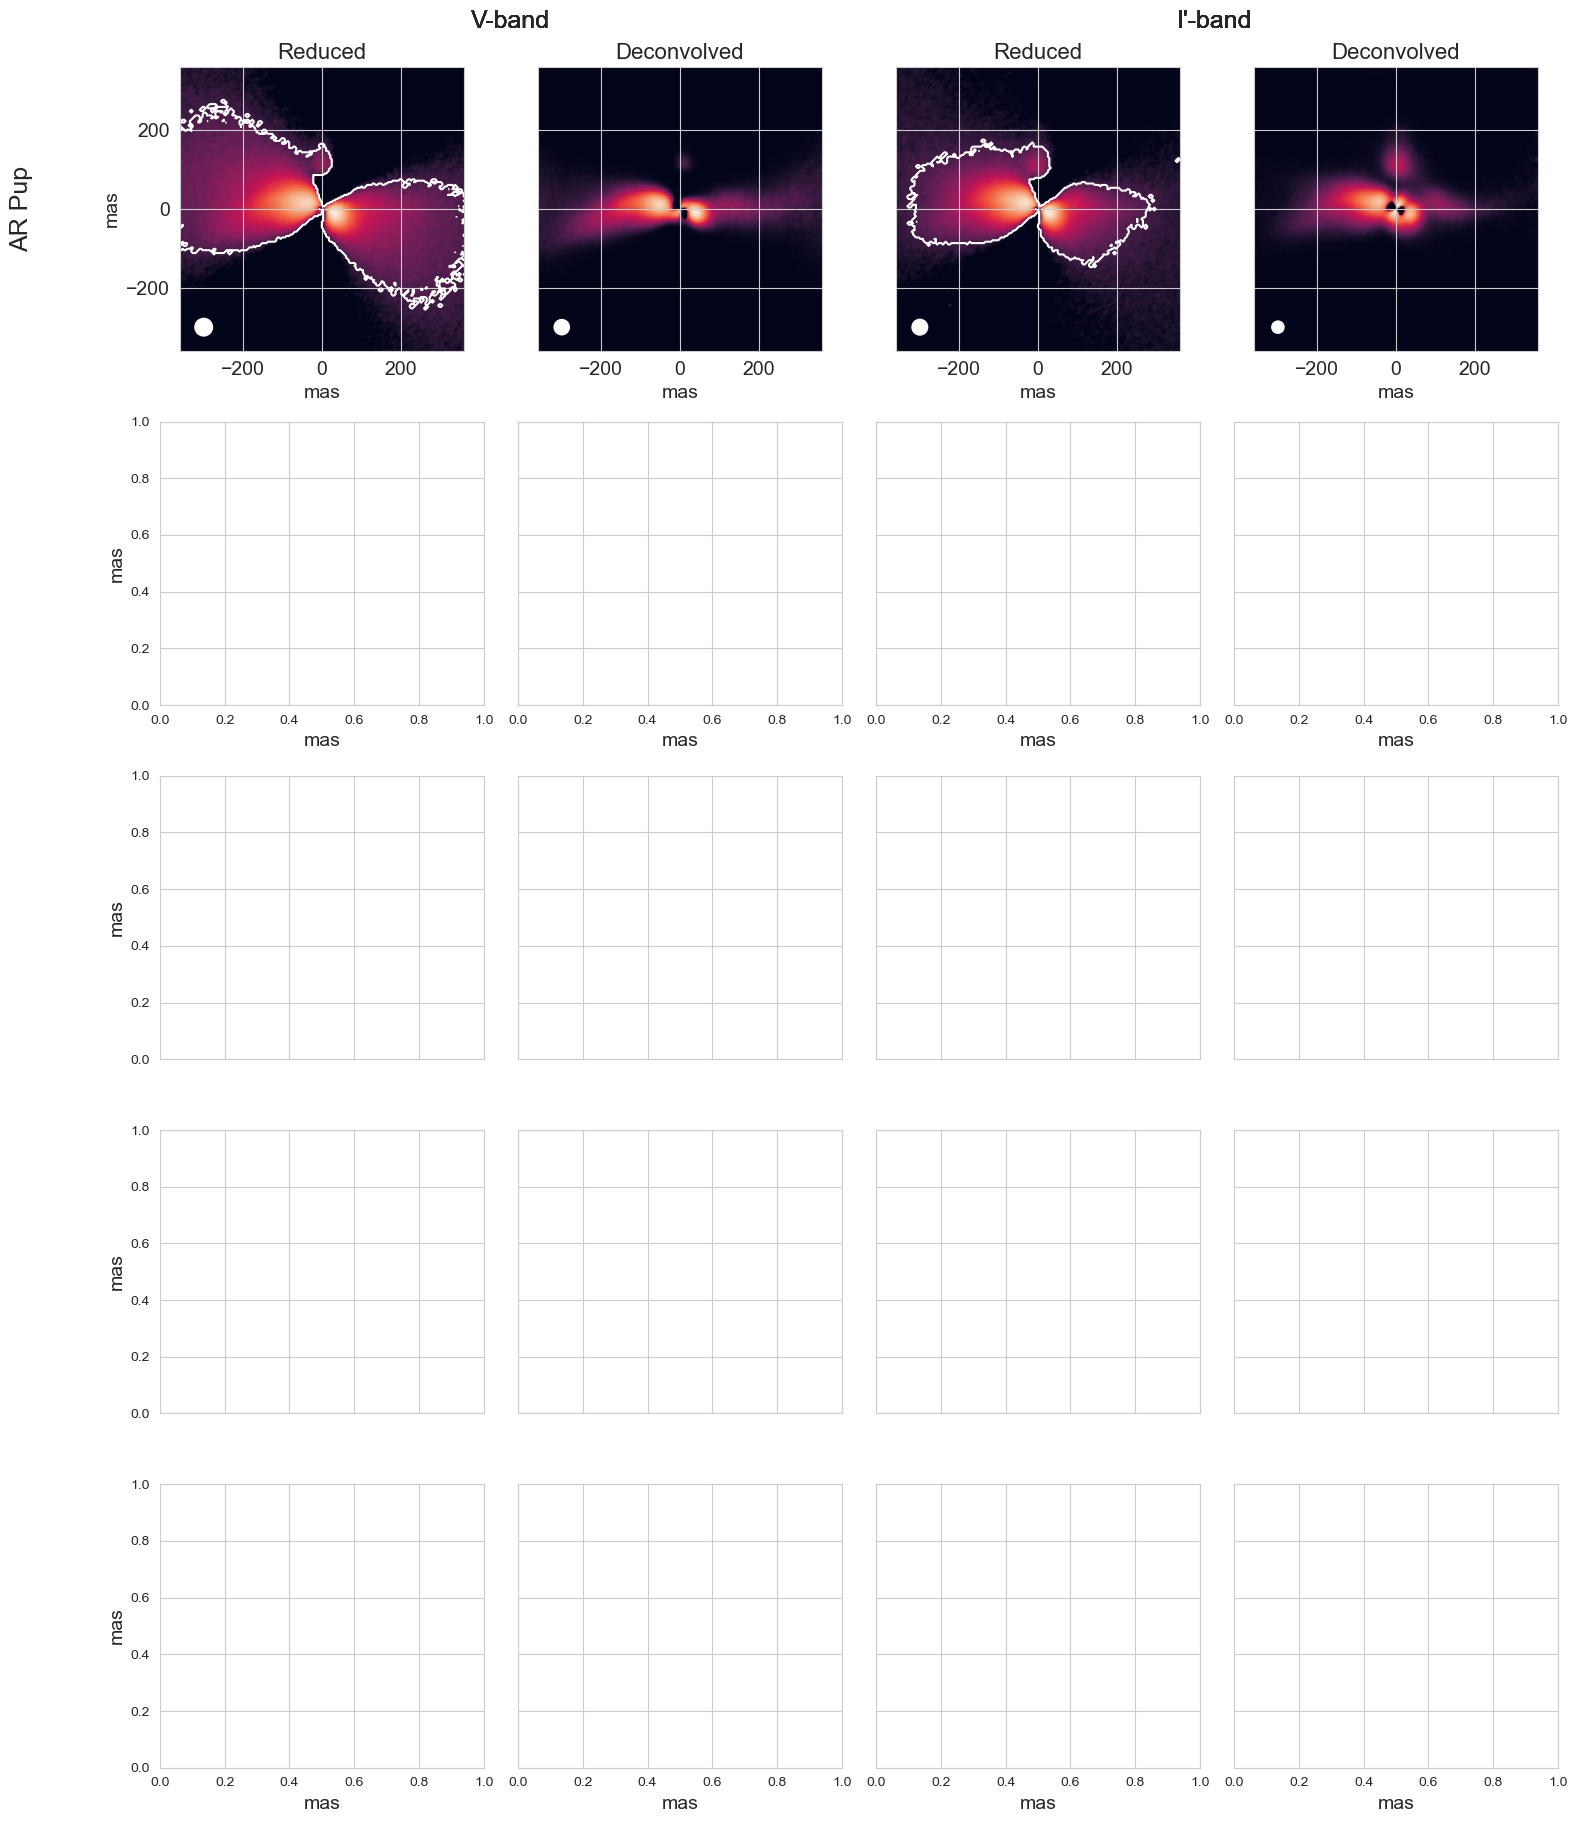

In [46]:
## stars=['AR_Pup_dc_notnorm','HR4049_20190107','HR4226','UMon_Katya','V709_Car']
stars = ['01.SCI_AR_Pup']
starnames = {'01.SCI_UMon': 'U Mon', '01.SCI_AR_Pup':'AR Pup'}
ps=3.6
band=['V','I']

fig, ax = plt.subplots(5, 4, figsize=(16, 18))

for i_st,star in enumerate(stars):
    print(star)
    dirdatd ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera+'/'
    dirdat ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

    fittypes=['1', '2']

    df_V=pd.read_csv(dirdat+star+'_'+'V'+'_df_out.csv')
    df_I=pd.read_csv(dirdat+star+'_'+'I'+'_df_out.csv')

    for fittype in fittypes:
        print(band[int(fittype)-1])
        
        psf,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr_Ref/'+camera+'/',band[int(fittype)-1])
        fwhm=find_FWHM (psf,n)*ps


         #Creating grid         
        xr = np.linspace(-n/2, n/2, num=n)
        yr = np.linspace(-n/2, n/2, num=n)
        x0 = 0.5
        y0 = 0.5
        xr = xr-x0
        yr = yr-y0
        X, Y = np.meshgrid(xr, yr)
        R = np.sqrt(X**2 + Y**2)
        phi = np.arctan(Y/X)

        q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
        u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
        pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear 

        I_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'I'+'/',band[int(fittype)-1])
        q_phi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'Q_phi'+'/',band[int(fittype)-1])
        pi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'PI'+'/',band[int(fittype)-1])
        fwhm_deconv=find_FWHM (I_decon,n)*ps


        if band[int(fittype)-1]=='V':
            q_phi_V=q_phi_corr
            pi_V=pi_corr
            fwhm_V=fwhm
            q_phi_deconv_V=q_phi_decon
            pi_deconv_V=pi_decon
            fwhm_deconv_V=fwhm_deconv

        if band[int(fittype)-1]=='I':
            q_phi_I=q_phi_corr
            pi_I=pi_corr
            fwhm_I=fwhm
            q_phi_deconv_I=q_phi_decon
            pi_deconv_I=pi_decon
            fwhm_deconv_I=fwhm_deconv

    images_list=[q_phi_V,q_phi_deconv_V,q_phi_I,q_phi_deconv_I]
    bandlist=['V','V','I','I']
    d=(n-1)/2*ps
    if i_st==0:
        lim=100
    else:
        lim=40
    for i_im, image1 in enumerate(images_list):

        image = np.arcsinh(image1)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


        ax[i_st,i_im].imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        ax[i_st,i_im].set_xlim(-lim * ps, lim * ps)
        ax[i_st,i_im].set_ylim(-lim * ps, lim * ps)
        ax[i_st,i_im].tick_params(axis='both',labelsize=14)
        if star==stars[0]: 
            circleloc=(-300,-300)
        else:
            circleloc=(-125,-125)
            
        if bandlist[i_im]=='V':
            if i_im==0:
                circle1 =plt.Circle(circleloc, (fwhm_V/2), color='w') 
                mask= image1>=df_V.xs('noise_q_phi_median',axis=1).median()*5
   
                mask=mask.astype(int)
                levels = [0,1]  # Adjust this as needed
                CS = ax[i_st,i_im].contour(X*ps, Y*ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

            else:
                circle1 =plt.Circle(circleloc, (fwhm_deconv_V/2), color='w') 

            ax[i_st,i_im].add_patch(circle1)
        else:
            if i_im==2:
                circle1 =plt.Circle(circleloc, (fwhm_I/2), color='w')  
                mask= image1>=df_I.xs('noise_q_phi_median',axis=1).median()*5
   
                mask=mask.astype(int)
                levels = [0,1]  # Adjust this as needed
                CS = ax[i_st,i_im].contour(X*ps, Y*ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

            else:
                circle1 =plt.Circle(circleloc, (fwhm_deconv_I/2), color='w') 
            ax[i_st,i_im].add_patch(circle1)


    col_titles = ['Reduced', 'Deconvolved','Reduced', 'Deconvolved']


    for axi, col_title in zip(ax[0], col_titles):
        axi.set_title(col_title, fontsize=16)

    ax[i_st, 0].text(-0.6, 0.5, starnames[star], transform=ax[i_st, 0].transAxes, fontsize=18, va='center', rotation=90)

for i in range(5):
    for j in range(4):
        ax[i, j].tick_params(labelleft=False, labelbottom=False)  # Hide all tick labels initially
    ax[i, 0].tick_params(labelleft=True)  # Show y-axis for the first column
    ax[i,0].set_ylabel('mas',fontsize=14)
        
    if i == 0 or i==1 or i == 4:
        for j in range(4):
            ax[i, j].tick_params(labelbottom=True)  # Show x-axis for the first and last row
            ax[i,j].set_xlabel('mas',fontsize=14)
    
    #ax[0,0].get_xaxis().set_visible(False)
    
    plt.tight_layout()
    fig.text(0.33, 1, 'V-band', fontsize=18, ha='center')
    fig.text(0.77, 1, "I'-band", fontsize=18, ha='center')
    
plt.savefig(figfolder+'Qphi_reduced+deconv.png',bbox_inches='tight')
plt.show()
plt.close()


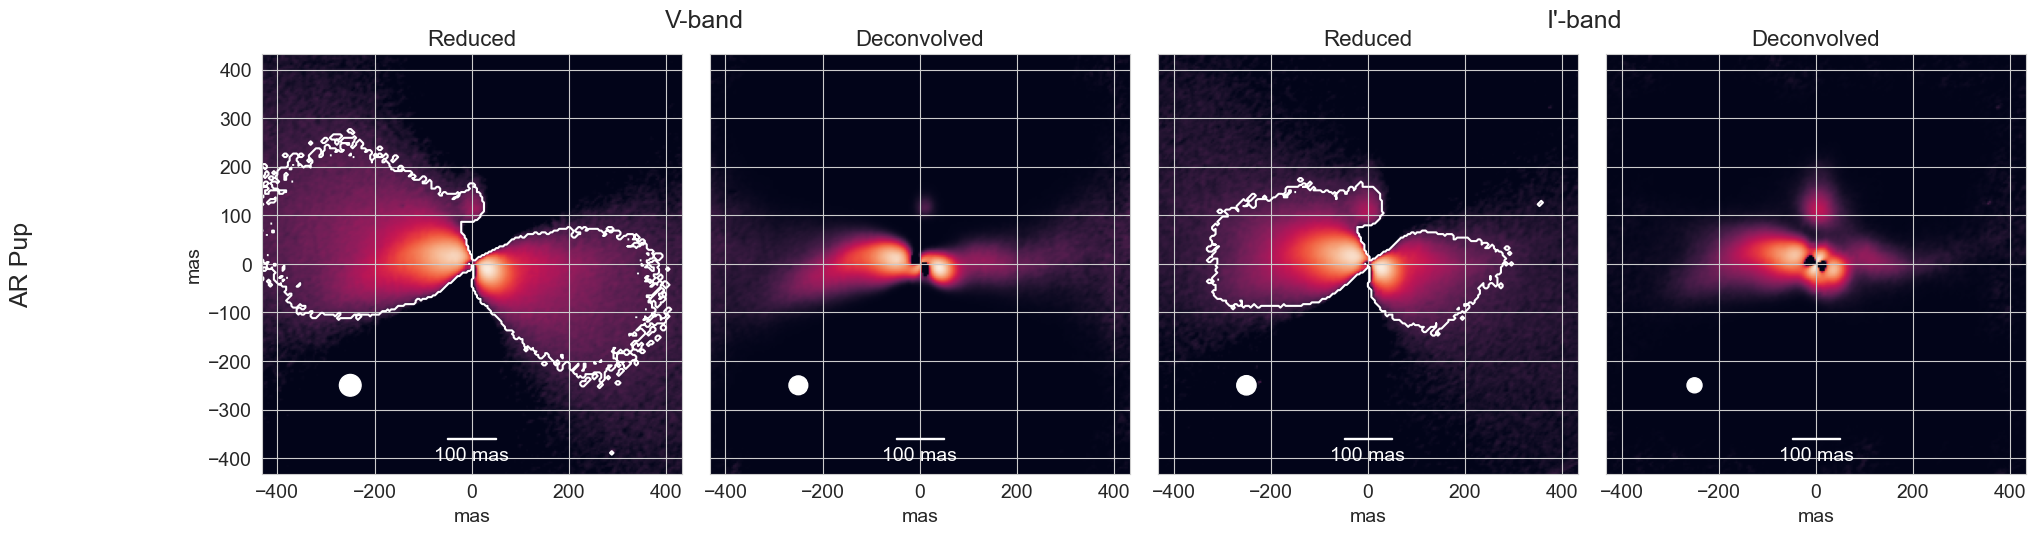

In [52]:

fig, ax = plt.subplots(1, 4, figsize=(20, 5)) # Create a 1x4 subplot grid

images_list = [q_phi_V, q_phi_deconv_V, q_phi_I, q_phi_deconv_I]
bandlist = ['V', 'V', 'I', 'I']
d = (n - 1) / 2 * ps
lim = 120 #constant limit

for i_im, image1 in enumerate(images_list):
    image = np.arcsinh(image1)
    max_val = np.max(image[int(n / 2 - lim / 2):int(n / 2 + lim / 2), int(n / 2 - lim / 2):int(n / 2 + lim / 2)])
    min_val = np.min(image[int(n / 2 - lim / 2):int(n / 2 + lim / 2), int(n / 2 - lim / 2):int(n / 2 + lim / 2)])

    ax[i_im].imshow(image, vmin=min_val, vmax=max_val, extent=(-d, d, d, -d))
    ax[i_im].set_xlim(-lim * ps, lim * ps)
    ax[i_im].set_ylim(-lim * ps, lim * ps)
    ax[i_im].tick_params(axis='both', labelsize=14)

    circleloc = (-250, -250)

    asb = AnchoredSizeBar(ax[i_im].transData,
                          lenghtmas,
                          str(lenghtmas) + " mas",
                          fontproperties=fp,
                          loc='lower center',
                          pad=0.1, borderpad=0.4, sep=5, size_vertical=2, #adjust size_vertical as needed
                          frameon=False, color='white')
    ax[i_im].add_artist(asb)

    if bandlist[i_im] == 'V':
        if i_im == 0:
            circle1 = plt.Circle(circleloc, (fwhm_V / 2), color='w')
            mask = image1 >= df_V.xs('noise_q_phi_median', axis=1).median() * 5
            mask = mask.astype(int)
            levels = [0, 1]
            CS = ax[i_im].contour(X * ps, Y * ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

        else:
            circle1 = plt.Circle(circleloc, (fwhm_deconv_V / 2), color='w')

        ax[i_im].add_patch(circle1)
    else:
        if i_im == 2:
            circle1 = plt.Circle(circleloc, (fwhm_I / 2), color='w')
            mask = image1 >= df_I.xs('noise_q_phi_median', axis=1).median() * 5
            mask = mask.astype(int)
            levels = [0, 1]
            CS = ax[i_im].contour(X * ps, Y * ps, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))

        else:
            circle1 = plt.Circle(circleloc, (fwhm_deconv_I / 2), color='w')
        ax[i_im].add_patch(circle1)

col_titles = ['Reduced', 'Deconvolved', 'Reduced', 'Deconvolved']

for axi, col_title in zip(ax, col_titles):
    axi.set_title(col_title, fontsize=16)

ax[0].text(-0.6, 0.5, starnames[star], transform=ax[0].transAxes, fontsize=18, va='center', rotation=90)

for j in range(4):
    ax[j].tick_params(labelleft=False, labelbottom=False)
ax[0].tick_params(labelleft=True)
ax[0].set_ylabel('mas', fontsize=14)

for j in range(4):
    ax[j].tick_params(labelbottom=True)
    ax[j].set_xlabel('mas', fontsize=14)

plt.tight_layout()
fig.text(0.33, 1, 'V-band', fontsize=18, ha='center')
fig.text(0.77, 1, "I'-band", fontsize=18, ha='center')

plt.savefig(figfolder + 'Qphi_reduced+deconv.png', bbox_inches='tight')
plt.show()
plt.close()

# For thesis

01.SCI_AR_Pup
V
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_V_I_meancombined.fits
1024
1.0000000000000003e-16
0.0
0.0
fwhm 44.607111536785105 38.656562349314385
I
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr_Ref/ZIMPOL/
*_I_I_meancombined.fits
1024
1.0000000000000003e-16
0.0
0.0
fwhm 39.764951577697815 30.936215528936128


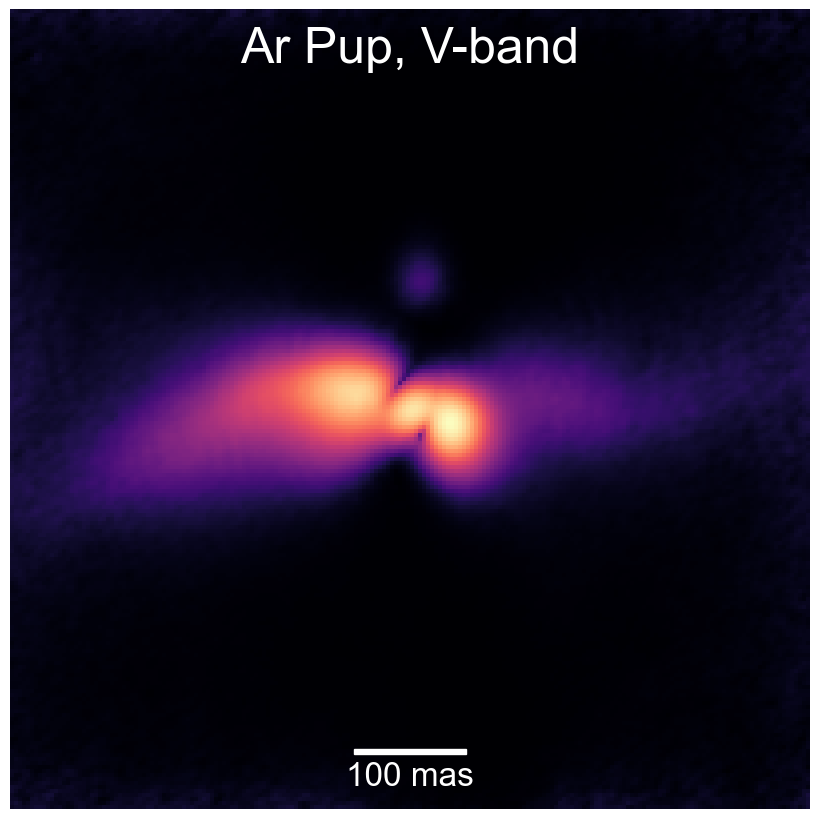

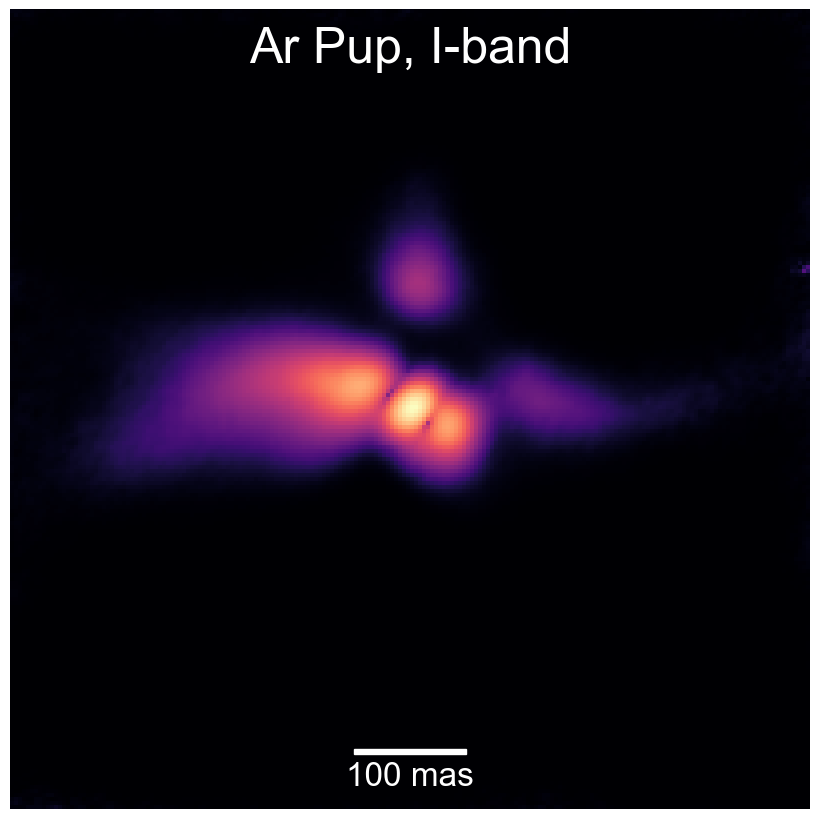

In [53]:

stars=['01.SCI_AR_Pup']
starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':'Ar Pup'}

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unresolved_images/'+camera+'/'

ps=3.6
band=['V','I']

for i_st,star in enumerate(stars):
    print(star)
    dirdat ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

    if star=='AR_Pup_dc_notnorm':
        dirdatd ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Deconvolution_corr_tel/'+star+'/'
    else:
        dirdatd ='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera+'/'
    
    fittypes=['1', '2']

    df_V=pd.read_csv(dirdat+star+'_'+'V'+'_df_out.csv')
    df_I=pd.read_csv(dirdat+star+'_'+'I'+'_df_out.csv')

    for fittype in fittypes:
        print(band[int(fittype)-1])
        
        psf,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr_Ref/'+camera+'/',band[int(fittype)-1])
        fwhm=find_FWHM (psf,n)*ps


         #Creating grid         
        xr = np.linspace(-n/2, n/2, num=n)
        yr = np.linspace(-n/2, n/2, num=n)
        x0 = 0.5
        y0 = 0.5
        xr = xr-x0
        yr = yr-y0
        X, Y = np.meshgrid(xr, yr)
        R = np.sqrt(X**2 + Y**2)
        phi = np.arctan(Y/X)

        if star=='01.SCI_AR_Pup':
            q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
            u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
            pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear 
        else:
            q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
            u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
            pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear 

        I_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'I'+'/',band[int(fittype)-1])
        q_phi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'Q_phi'+'/',band[int(fittype)-1])
        pi_decon, _, _, _, _,_,_=  LoadImage(dirdatd +'deconvolved_'+'PI'+'/',band[int(fittype)-1])
        
        fwhm_deconv=find_FWHM (I_decon,n)*ps
        print('fwhm',fwhm, fwhm_deconv)


        if band[int(fittype)-1]=='V':
            q_phi_V=q_phi_corr
            pi_V=pi_corr
            fwhm_V=fwhm
            q_phi_deconv_V=q_phi_decon
            pi_deconv_V=pi_decon
            fwhm_deconv_V=fwhm_deconv

        if band[int(fittype)-1]=='I':
            q_phi_I=q_phi_corr
            pi_I=pi_corr
            fwhm_I=fwhm
            q_phi_deconv_I=q_phi_decon
            pi_deconv_I=pi_decon
            fwhm_deconv_I=fwhm_deconv

            
            
            
    
    images_list=[pi_deconv_V,pi_deconv_I]
    bandlist=['V','I']
    d=(n-1)/2*ps
    if i_st==0:
        lim=100
    else:
        lim=50
        
        # Loop through images to create plots without white borders
    for i_im, image1 in enumerate(images_list):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        # Apply arcsinh scaling to the image
        image = np.arcsinh(image1)
        max_val = np.max(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])
        min_val = np.min(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])

        # Display the image
        ax.imshow(image, vmin=min_val, vmax=max_val, extent=(-d, d, d, -d), cmap='magma')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.tick_params(axis='both', labelsize=14)

        # Add the scale bar
        fp = FontProperties()
        fp.set_size(24)
        lenghtmas = 100
        size_bar_thickness = 5 if star == '01.SCI_AR_Pup' else 2

        asb = AnchoredSizeBar(
            ax.transData,
            lenghtmas,
            f"{lenghtmas} mas",
            fontproperties=fp,
            loc='lower center',
            pad=0.1,
            borderpad=0.4,
            sep=5,
            size_vertical=size_bar_thickness,
            frameon=False,
            color='white'
        )
        ax.add_artist(asb)

        # Add labels and text
        ax.text(0.5, 0.95, starnames[star]+', '+bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=36, color='white', va='center', ha='center')
        #ax.text(0.02, 0.91, bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=22, color='white', va='center')

        # Add FWHM circle
        circleloc = (-300, -300) if star == stars[0] else (-125, -125)
        circle_radius = (fwhm_V / 2) if bandlist[i_im] == 'V' else (fwhm_deconv_I / 2)
        circle1 = plt.Circle(circleloc, circle_radius, color='w')
        #ax.add_patch(circle1)

        # Remove axes and borders
        ax.axis('off')

        # Remove white border by adjusting layout and save
        plt.tight_layout(pad=0)
        plt.savefig(figfolder + f'{star}_{bandlist[i_im]}_PI_deconv.png', bbox_inches='tight', pad_inches=0, dpi=300)
        plt.show()
        plt.close()


In [36]:
fittype = ['I','PI','Q_phi']

In [1]:
def Loadimage_IRDIS(star,fittype,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/Deconvolution_corr_tel+unres/deconvolved_'+fittype+'/'
    ifile = '*.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            if fittype=='Q_phi': image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    return image


dirdat_IRDIS = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' #data coming from
irdis_stars=['01.SCI_UMon']
starnames= {'01.SCI_UMon': 'U Mon'}



ps=12.27

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unresolved_images/IRDIS_Extra_images/'
createfolder(figfolder)


for i_st,star in enumerate(irdis_stars):
    
   #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    X, Y = np.meshgrid(xr, yr)
    R = np.sqrt(X**2 + Y**2)
    phi = np.arctan(Y/X)
   
    pi_decon=Loadimage_IRDIS(star,'I',dirdat_IRDIS)
    q_phi_decon=Loadimage_IRDIS(star,'Q_phi',dirdat_IRDIS)
    
    
    
   
    q_phi_deconv_H=q_phi_decon
    pi_deconv_H=pi_decon
   
        
            
            
            
    
    images_list=[pi_deconv_H]
    bandlist=['H']
    d=(n-1)/2*ps
    lim=20
        
        # Loop through images to create plots without white borders
    for i_im, image1 in enumerate(images_list):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        # Apply arcsinh scaling to the image
        image = np.arcsinh(image1)
        max_val = np.max(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])
        min_val = np.min(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])

        # Display the image
        ax.imshow(image, vmin=min_val, vmax=max_val, extent=(-d, d, d, -d), cmap='magma')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.tick_params(axis='both', labelsize=14)

        # Add the scale bar
        fp = FontProperties()
        fp.set_size(24)
        lenghtmas = 100
        size_bar_thickness = 5 if star == '01.SCI_AR_Pup' else 2

        asb = AnchoredSizeBar(
            ax.transData,
            lenghtmas,
            f"{lenghtmas} mas",
            fontproperties=fp,
            loc='lower center',
            pad=0.1,
            borderpad=0.4,
            sep=5,
            size_vertical=size_bar_thickness,
            frameon=False,
            color='white'
        )
        ax.add_artist(asb)

        # Add labels and text
        ax.text(0.5, 0.95, starnames[star]+', '+bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=36, color='white', va='center', ha='center')
        #ax.text(0.02, 0.91, bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=22, color='white', va='center')

        # Add FWHM circle
        circleloc = (-300, -300) if star == stars[0] else (-125, -125)
        circle_radius = (fwhm_V / 2) if bandlist[i_im] == 'V' else (fwhm_deconv_I / 2)
        circle1 = plt.Circle(circleloc, circle_radius, color='w')
        #ax.add_patch(circle1)

        # Remove axes and borders
        ax.axis('off')

        # Remove white border by adjusting layout and save
        plt.tight_layout(pad=0)
        plt.savefig(figfolder + f'{star}_{bandlist[i_im]}_PI_deconv.png', bbox_inches='tight', pad_inches=0, dpi=300)
        plt.show()
        plt.close()
        
        
        
        
    images_list=[q_phi_deconv_H]
    bandlist=['H']
    d=(n-1)/2*ps
    lim=20
        
        # Loop through images to create plots without white borders
    for i_im, image1 in enumerate(images_list):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        # Apply arcsinh scaling to the image
        image = np.arcsinh(image1)
        max_val = np.max(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])
        min_val = np.min(image[int(n/2 - lim/2):int(n/2 + lim/2), int(n/2 - lim/2):int(n/2 + lim/2)])

        # Display the image
        ax.imshow(image, vmin=min_val, vmax=max_val, extent=(-d, d, d, -d), cmap='magma')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.tick_params(axis='both', labelsize=14)

        # Add the scale bar
        fp = FontProperties()
        fp.set_size(24)
        lenghtmas = 100
        size_bar_thickness = 5 if star == '01.SCI_AR_Pup' else 2

        asb = AnchoredSizeBar(
            ax.transData,
            lenghtmas,
            f"{lenghtmas} mas",
            fontproperties=fp,
            loc='lower center',
            pad=0.1,
            borderpad=0.4,
            sep=5,
            size_vertical=size_bar_thickness,
            frameon=False,
            color='white'
        )
        ax.add_artist(asb)

        # Add labels and text
        ax.text(0.5, 0.95, starnames[star]+', '+bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=36, color='white', va='center', ha='center')
        #ax.text(0.02, 0.91, bandlist[i_im] + '-band', transform=ax.transAxes, fontsize=22, color='white', va='center')

        # Add FWHM circle
        circleloc = (-300, -300) if star == stars[0] else (-125, -125)
        circle_radius = (fwhm_V / 2) if bandlist[i_im] == 'V' else (fwhm_deconv_I / 2)
        circle1 = plt.Circle(circleloc, circle_radius, color='w')
        #ax.add_patch(circle1)

        # Remove axes and borders
        ax.axis('off')

        # Remove white border by adjusting layout and save
        plt.tight_layout(pad=0)
        plt.savefig(figfolder + f'{star}_{bandlist[i_im]}_qphi_deconv.png', bbox_inches='tight', pad_inches=0, dpi=300)
        plt.show()
        plt.close()


NameError: name 'star' is not defined